In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import torch
import sklearn
import itertools
import networkx          as nx
import seaborn           as sns
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from   sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from   som                   import train_SOM, distSq, find_BMU, update_weights

In [4]:
# Dimensions of the SOM grid
m   = 10
n   = 10

# Number of training examples
n_x = 3000

In [5]:
rand = np.random.RandomState(0)

In [6]:
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [7]:
np.unique(penguins['island'], return_counts=True)

(array(['Biscoe', 'Dream', 'Torgersen'], dtype=object), array([163, 123,  47]))

In [8]:
le = LabelEncoder()

In [9]:
for string in ['island', 'species', 'sex']:
    penguins[string] = le.fit_transform(penguins[string])

penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...,...,...
338,2,0,47.2,13.7,214.0,4925.0,0
340,2,0,46.8,14.3,215.0,4850.0,0
341,2,0,50.4,15.7,222.0,5750.0,1
342,2,0,45.2,14.8,212.0,5200.0,0


In [10]:
np.unique(penguins['island'], return_counts=True)

(array([0, 1, 2]), array([163, 123,  47]))

In [11]:
# Retain four dimensions.
labels  = ['species_short', 'island', 'sex'] 
scalars = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

In [12]:
scaled_penguin_data = StandardScaler().fit_transform(penguins[scalars])
scaled_penguin_data

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 ],
       ...,
       [ 1.17338426, -0.74499437,  1.50292796,  1.91906927],
       [ 0.22108196, -1.20271231,  0.78837197,  1.23499466],
       [ 1.08181673, -0.54156417,  0.85982757,  1.48374906]])

In [13]:
for i, x in enumerate(scalars):
    penguins[x] = scaled_penguin_data[:,i]

penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,-0.896042,0.780732,-1.426752,-0.568475,1
1,0,2,-0.822788,0.119584,-1.069474,-0.506286,0
2,0,2,-0.676280,0.424729,-0.426373,-1.190361,0
4,0,2,-1.335566,1.085877,-0.569284,-0.941606,0
5,0,2,-0.859415,1.747026,-0.783651,-0.692852,1
...,...,...,...,...,...,...,...
338,2,0,0.587352,-1.762145,0.931283,0.892957,0
340,2,0,0.514098,-1.457000,1.002739,0.799674,0
341,2,0,1.173384,-0.744994,1.502928,1.919069,1
342,2,0,0.221082,-1.202712,0.788372,1.234995,0


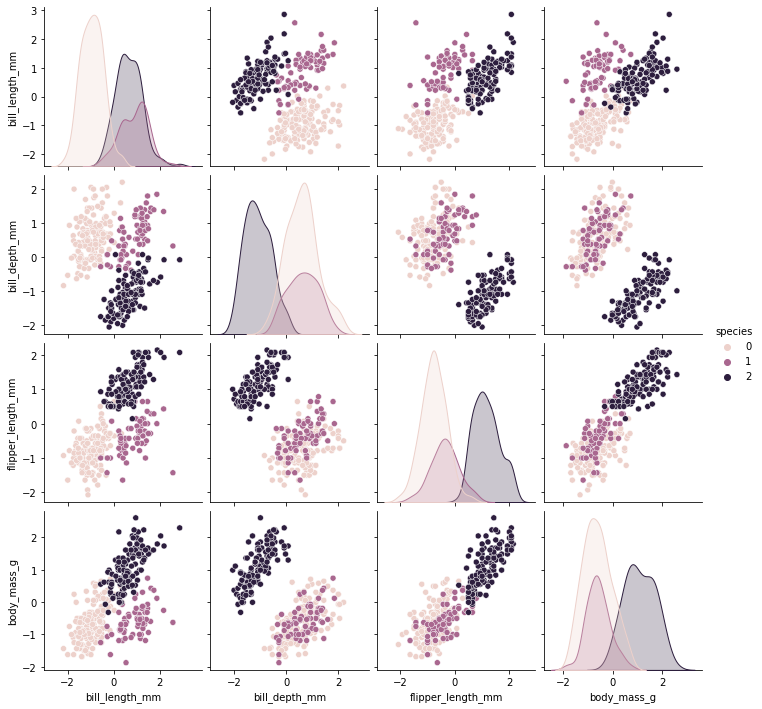

In [14]:
# add SOM as diff colour
x = sns.pairplot(penguins[['species'] + scalars], hue='species')

In [15]:
#training set
train_data = np.array(penguins[scalars])
train_data

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 ],
       ...,
       [ 1.17338426, -0.74499437,  1.50292796,  1.91906927],
       [ 0.22108196, -1.20271231,  0.78837197,  1.23499466],
       [ 1.08181673, -0.54156417,  0.85982757,  1.48374906]])

In [16]:
# Initialize the SOM randomly
rand = np.random.RandomState(0)
SOM  = rand.normal(loc=0.0, scale=1.0, size=(m, n, 4)).astype(float)
SOM.shape

(10, 10, 4)

In [17]:
SOM[0,0]

array([1.76405235, 0.40015721, 0.97873798, 2.2408932 ])

In [18]:
# update SOM
nvec, zSOM, SOM, rates, radii, lr_decay = train_SOM(SOM, train_data, nepochs=100, rand=rand)

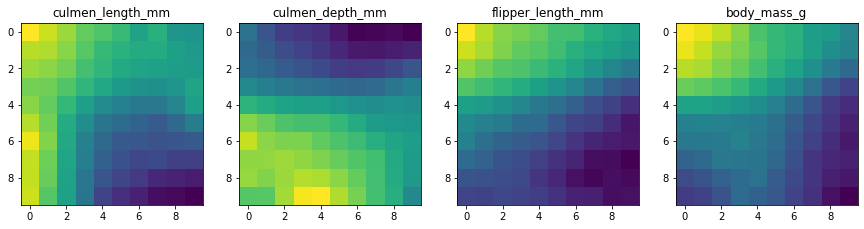

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))

for i in range(4):
    ax[i].imshow(SOM[:, :,i])

ax[0].title.set_text('culmen_length_mm')
ax[1].title.set_text('culmen_depth_mm')
ax[2].title.set_text('flipper_length_mm')
ax[3].title.set_text('body_mass_g')

In [20]:
som_df = []

for i in range(10):
    for j in range(10):
        som_df.append(np.concatenate(([3.], SOM[i,j], [i], [j])))

som_df = pd.DataFrame(som_df, columns=['species'] + scalars + ['SOM_I', 'SOM_J'])
som_df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,SOM_I,SOM_J
0,3.0,1.398429,-0.447947,1.855957,1.832214,0.0,0.0
1,3.0,1.174896,-0.799161,1.530130,1.728385,0.0,1.0
2,3.0,0.965151,-1.044079,1.314805,1.534714,0.0,2.0
3,3.0,0.713042,-1.132666,1.247686,1.262261,0.0,3.0
4,3.0,0.606567,-1.190264,1.140735,0.935232,0.0,4.0
...,...,...,...,...,...,...,...
95,3.0,-1.074082,1.116396,-0.690858,-0.442094,9.0,5.0
96,3.0,-1.193418,0.857464,-0.858102,-0.637955,9.0,6.0
97,3.0,-1.349862,0.559727,-0.864840,-0.839875,9.0,7.0
98,3.0,-1.389113,0.341798,-1.014446,-1.142235,9.0,8.0


In [21]:
penguins = penguins.append(som_df)
penguins

/tmp/ipykernel_247013/2086849114.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  penguins = penguins.append(som_df)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,SOM_I,SOM_J
0,0.0,2.0,-0.896042,0.780732,-1.426752,-0.568475,1.0,NaN,NaN
1,0.0,2.0,-0.822788,0.119584,-1.069474,-0.506286,0.0,NaN,NaN
2,0.0,2.0,-0.676280,0.424729,-0.426373,-1.190361,0.0,NaN,NaN
4,0.0,2.0,-1.335566,1.085877,-0.569284,-0.941606,0.0,NaN,NaN
5,0.0,2.0,-0.859415,1.747026,-0.783651,-0.692852,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
95,3.0,NaN,-1.074082,1.116396,-0.690858,-0.442094,NaN,9.0,5.0
96,3.0,NaN,-1.193418,0.857464,-0.858102,-0.637955,NaN,9.0,6.0
97,3.0,NaN,-1.349862,0.559727,-0.864840,-0.839875,NaN,9.0,7.0
98,3.0,NaN,-1.389113,0.341798,-1.014446,-1.142235,NaN,9.0,8.0


In [22]:
real_penguins = penguins[penguins['species'].values  <  3.]
som_penguins  = penguins[penguins['species'].values == -1.]

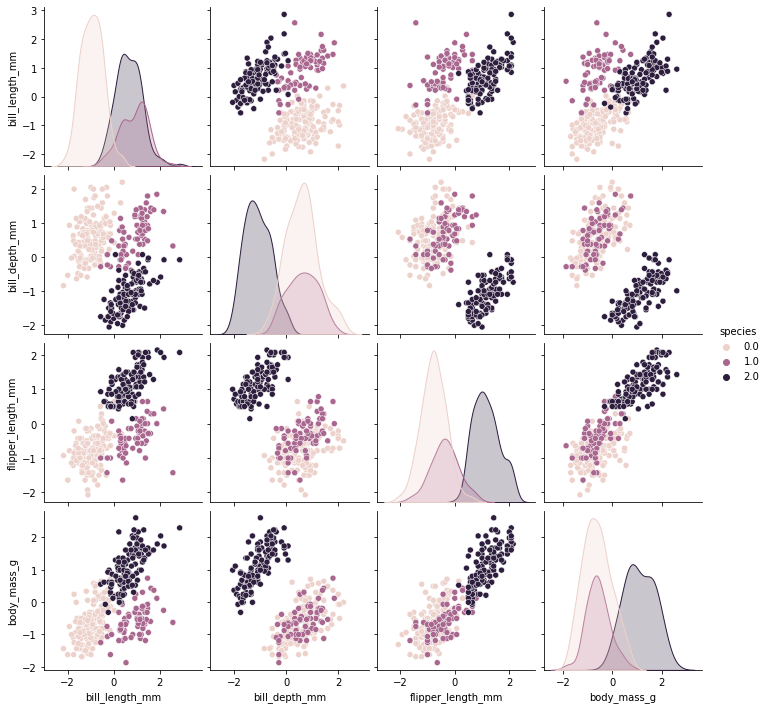

In [23]:
g = sns.pairplot(real_penguins[['species'] + scalars], hue='species')

In [24]:
G = nx.Graph()

In [25]:
for i in np.arange(len(real_penguins)):    
    G.add_node(i, **dict(real_penguins.iloc[i]))

In [26]:
len(G.nodes)

333

In [27]:
G.nodes[0]

{'species': 0.0,
 'island': 2.0,
 'bill_length_mm': -0.8960418897725922,
 'bill_depth_mm': 0.7807321043966328,
 'flipper_length_mm': -1.4267515672137063,
 'body_mass_g': -0.5684747832140795,
 'sex': 1.0,
 'SOM_I': nan,
 'SOM_J': nan}

In [28]:
uislands = np.unique(real_penguins['island'].values)
uislands

array([0., 1., 2.])

In [29]:
for island in [0., 1., 2.]:
    idx   = np.arange(len(real_penguins))[real_penguins['island'].values == island]
    
    edges = list(itertools.combinations(idx, 2))
    
    G.add_edges_from(edges)

In [30]:
# pos = np.c_[penguins['bill_depth_mm'], penguins['bill_length_mm']]

In [31]:
def island_filter(nn):
    return  G.nodes[nn]['island'] == 2.

In [32]:
I  = nx.subgraph_view(G, filter_node=island_filter)
I.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125))

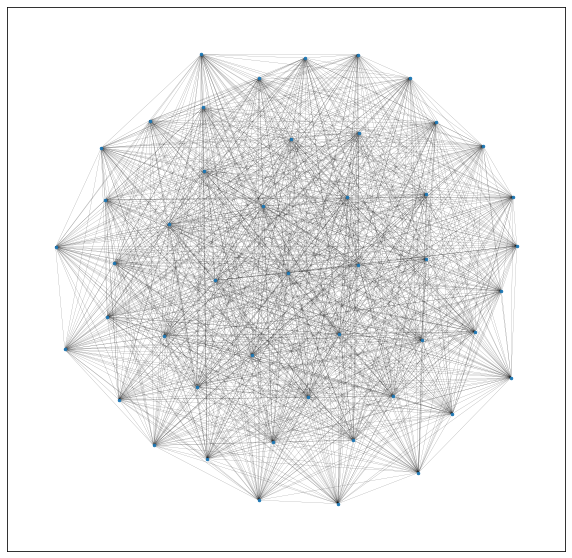

In [33]:
ubax1 = plt.subplots(1, 1, figsize=(10,10))

# keywords:  nx.draw_networkx?
nx.draw(I,\
        with_labels=False,\
        font_weight='bold',\
        font_color='k',\
        node_size=6,\
        width=0.1)

limits = plt.axis('on')

In [34]:
# nx.draw_networkx?

# Done.